### Imports

In [1]:
import torch
import pandas as pd
import os
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, default_data_collator
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_metric
from transformers import EarlyStoppingCallback

### Config

In [2]:
open_source_model_name = "microsoft/trocr-base-handwritten"
save_model_name = f"models/{open_source_model_name.split('/')[-1]}-finetuned"

In [3]:
dataset_path = 'dataset/dataset_training/'
train_dataset_path = os.path.join(dataset_path, 'train')
val_dataset_path = os.path.join(dataset_path, 'val')

In [4]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

CUDA available: True
CUDA version: 11.8


### Load Dataset

In [5]:
train_df_list = os.listdir(train_dataset_path)
val_df_list = os.listdir(val_dataset_path)

train_df_jpg_list = [train_df_list[i] for i in range(len(train_df_list)) if train_df_list[i].endswith('.jpg')]
val_df_jpg_list = [val_df_list[i] for i in range(len(val_df_list)) if val_df_list[i].endswith('.jpg')]

In [6]:
train_df = pd.DataFrame(columns=['file_name', 'text'])
val_df = pd.DataFrame(columns=['file_name', 'text'])

for i in range(len(train_df_jpg_list)):
    text_file = f"{train_df_jpg_list[i].split('.')[0]}.txt"
    with open(os.path.join(dataset_path, 'train', text_file), 'r') as f:
        text = f.read()
    train_df.loc[i] = {'file_name': train_df_jpg_list[i], 'text': text}

for i in range(len(val_df_jpg_list)):
    text_file = f"{val_df_jpg_list[i].split('.')[0]}.txt"
    with open(os.path.join(dataset_path, 'val', text_file), 'r') as f:
        text = f.read()
    val_df.loc[i] = {'file_name': val_df_jpg_list[i], 'text': text}

In [7]:
train_df.head()

,file_name,text
0,0_0.jpg,Lüdtke
1,0_1.jpg,Markus
2,0_11.jpg,15.04.2024
3,0_2.jpg,3366806
4,0_3.jpg,luedtke@gmx.de


In [8]:
val_df.head()

,file_name,text
0,31_0.jpg,Heydrich
1,31_1.jpg,Tanja
2,31_11.jpg,22.04.2024
3,31_2.jpg,2053157
4,31_3.jpg,hey@web.de


### Dataset Class

In [9]:
class Dataset:
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = str(self.df['text'][idx])  # Convert text to string explicitly
        
        # Prepare image (i.e. resize + normalize)
        image_path = os.path.join(self.root_dir, file_name)  # Create full file path
        image = Image.open(image_path).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        
        # Add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                           padding="max_length", 
                                           max_length=self.max_target_length).input_ids
        
        # Important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

### Dataset

In [10]:
processor = TrOCRProcessor.from_pretrained(open_source_model_name)
train_dataset = Dataset(root_dir=train_dataset_path,
                           df=train_df,
                           processor=processor)
eval_dataset = Dataset(root_dir=val_dataset_path,
                           df=val_df,
                           processor=processor)

/home/sonotokay/miniconda3/envs/everything/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [11]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 543
Number of validation examples: 109


### Examples

In [12]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


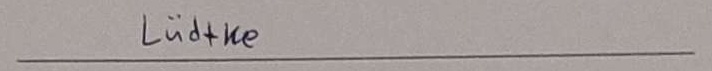

In [13]:
image = Image.open(os.path.join(train_dataset.root_dir , train_df['file_name'][0])).convert("RGB")
image

In [14]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Lüdtke


### Training

In [15]:
model = VisionEncoderDecoderModel.from_pretrained(open_source_model_name)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [22]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    num_train_epochs=50,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=False, 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    load_best_model_at_end=True,
)

In [23]:
cer_metric = load_metric("cer", trust_remote_code=True)

In [24]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [25]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.image_processor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
    callbacks=[EarlyStoppingCallback(5)]
)
trainer.train()

Step,Training Loss,Validation Loss,Cer
200,0.281000,0.301348,0.090041
400,0.436700,0.371059,0.099591
600,0.192200,0.548498,0.129604
800,0.100600,0.551576,0.128240
1000,0.094300,0.472684,0.106412
1200,0.000100,0.386256,0.092769
1400,0.005700,0.448441,0.084584
1600,0.000200,0.469808,0.111869
1800,0.000100,0.495339,0.091405
2000,0.000000,0.460675,0.095498


/home/sonotokay/miniconda3/envs/everything/lib/python3.10/site-packages/transformers/generation/utils.py:1256: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go in

TrainOutput(global_step=3400, training_loss=0.11652354135456602, metrics={'train_runtime': 3632.341, 'train_samples_per_second': 7.475, 'train_steps_per_second': 0.936, 'total_flos': 2.031594293554053e+19, 'train_loss': 0.11652354135456602, 'epoch': 50.0})

In [26]:
results = trainer.evaluate(eval_dataset=eval_dataset)
print(results)

{'eval_loss': 0.4586925804615021, 'eval_cer': 0.0927694406548431, 'eval_runtime': 43.0673, 'eval_samples_per_second': 2.531, 'eval_steps_per_second': 0.325, 'epoch': 50.0}


### Save Model

In [27]:
trainer.save_model(save_model_name)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


### Try Model

#### Imports

In [ ]:
processor = TrOCRProcessor.from_pretrained(open_source_model_name)
model = VisionEncoderDecoderModel.from_pretrained(save_model_name)

In [31]:
print("Predicted; True")
for i, eval in enumerate(eval_dataset):
    pixel_values = eval['pixel_values'].unsqueeze(0)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    real_text = val_df['text'][i]
    print(generated_text, real_text)

Predicted; True
LüLüde Lüdtke
Mankas Markus
3366806 3366806
luedtke@mx.de luedtke@gmx.de
Lüdke Lüdtke
Mila Mila
6b 6b
Schumannstraße|10 Schumannstrasse|10
28213 28213
Bremen Bremen
Finn Finn
6B 6B
Bremen Bremen
283009 28309
Marschstraße|2 Marschstrasse|2
Merschristian@g@mx.de merschristian@gmx.de
434973 4349733
Chriftian Christian
Miermann Mersmann
Mersmann Mersmann
Gunnar Gunnar
Dussen Dussen
12A 12A
Robotik Robotik
Band Band


KeyboardInterrupt: 